<a href="https://colab.research.google.com/github/rylan-berry/DataScienceExercises2025-2026/blob/main/RylaBerrU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Analyzing Spongebob Viewership on Episode Release**

##Installs & Imports

In [33]:
!pip install preliz

In [34]:
import preliz as pz

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

##Context

Spongebob Squarepants is a popular TV series produced by Nickelodeon. The series is primarily a comedy aimed at kids. Lets quantify how popular espisodes are on average.

##Previous Knowledge



As a popular TV series, I think most of the viewership of the show will be around a decent range, before going down towards 0. This about describes a high variance, low kurtois, and right skew distribution. Important info, we're looking at how many people were watching when the episodes first went on air instead of constant viewership.

##Data and Data Collection

The data was gathered from www.kaggle.com, our dataset itself is at https://www.kaggle.com/datasets/myticalcat/spongebob-squarepants-episodes-dataset, and I also stored the dataset into github for ease of access. Moving on, the main focus from this dataset is the number of viewers when the episode airs. The data includes strings that explain a bit more about the data or to say we don't know anything about certain viewerships on episodes, so we scrubbed out anything that is a string that would be challengeing to convert into a number, and anything where the number is not listed. The data is also converted to be given as in terms of thousands instead of millions for the sake of the accuracy.

In [38]:
#I had gemini fix the URL since I didn't know you had to use a special github url
episode_data = pd.read_csv("https://raw.githubusercontent.com/rylan-berry/DataScienceExercises2025-2026/main/spongebob_episodes.csv")

In [39]:
raw_num_of_viewers = episode_data["U.S. viewers (millions)"]
#scrubs dataset of any hard to handle strings and any episodes that don't have listed viewer counts
errors = np.zeros_like(raw_num_of_viewers)
for i, num in enumerate(raw_num_of_viewers):
  try:
    n = float(num)
  except ValueError:
    errors[i] = 1
    continue
  if(np.isnan(n)):
    errors[i] = 1

num_of_viewers = raw_num_of_viewers.loc[errors == False]

#converts all remaining values to floats
num_of_viewers = num_of_viewers.apply(pd.to_numeric)
num_of_viewers

,U.S. viewers (millions)
0,2.96
1,2.96
2,2.96
3,2.51
4,2.51
...,...
568,0.20
569,0.18
570,0.18
571,0.16


In [40]:
num_of_viewers = num_of_viewers * 1000
num_of_viewers.name = "U.S. viewers (thousands)"
num_of_viewers

,U.S. viewers (thousands)
0,2960.0
1,2960.0
2,2960.0
3,2510.0
4,2510.0
...,...
568,200.0
569,180.0
570,180.0
571,160.0


(array([ 80.,  79.,  98., 110.,  95.,  57.,  29.,   7.,   2.,   2.]),
 array([  80.,  928., 1776., 2624., 3472., 4320., 5168., 6016., 6864.,
        7712., 8560.]),
 <BarContainer object of 10 artists>)

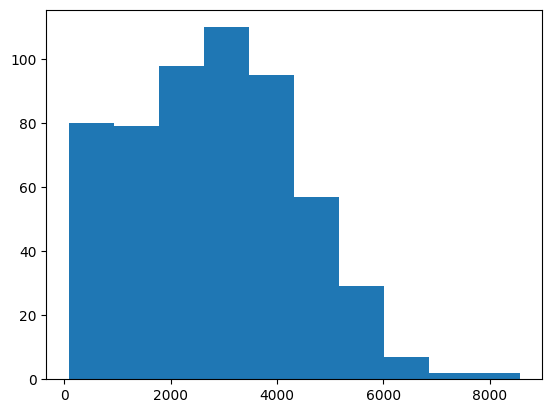

In [41]:
plt.hist(num_of_viewers)

##Likelyhood & Priors

After looking at the data, I believe a Negaitve Binomial would match the data. So below is what it would look like. I think the mean should be arround 3000, and the number needs to be above zero, so the Gamma is pretty good for this. I think the variance will be small, which is where having a low alpha comes in, so I just reused the Gamma and gave it a mean of about two.

<Axes: >

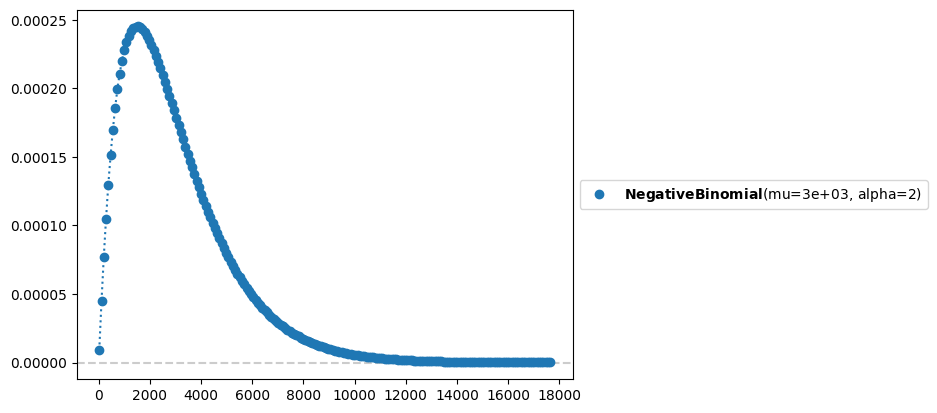

In [53]:
#Likelyhood
pz.NegativeBinomial(mu=3000, alpha=2).plot_pdf()

<Axes: >

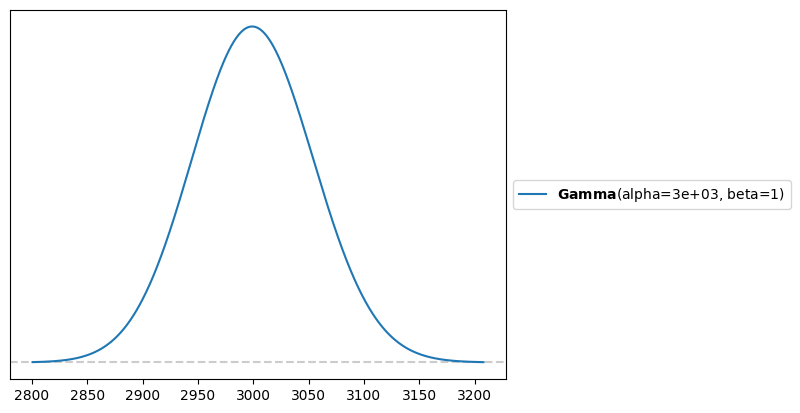

In [36]:
pz.Gamma(alpha = 3000, beta = 1).plot_pdf()
#Prior for the mu

<Axes: >

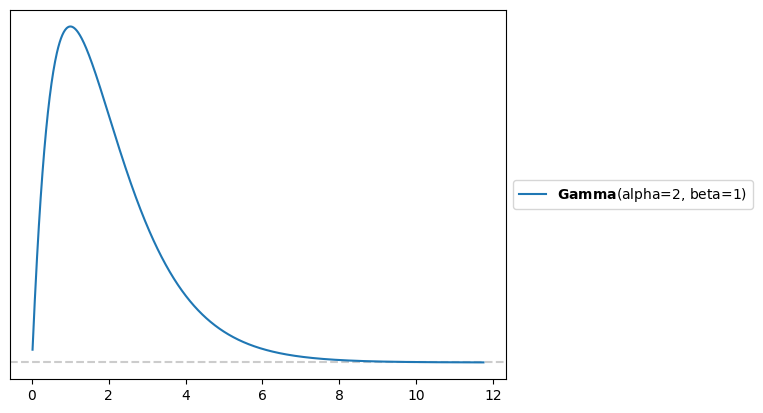

In [50]:
pz.Gamma(alpha = 2, beta = 1).plot_pdf()
#Prior for the alpha

##The PYMC Model

In [ ]:
with pm.Model() as viewer_model:

  μ = pm.Gamma("mu", alpha=3000.0, beta=1.0)
  α = pm.Gamma("alpha", alpha=2.0, beta=1.0)

  y = pm.NegativeBinomial("y", mu = μ, alpha = α, observed = num_of_viewers)

  sample_data = pm.sample()

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'mu'}>],
      dtype=object)

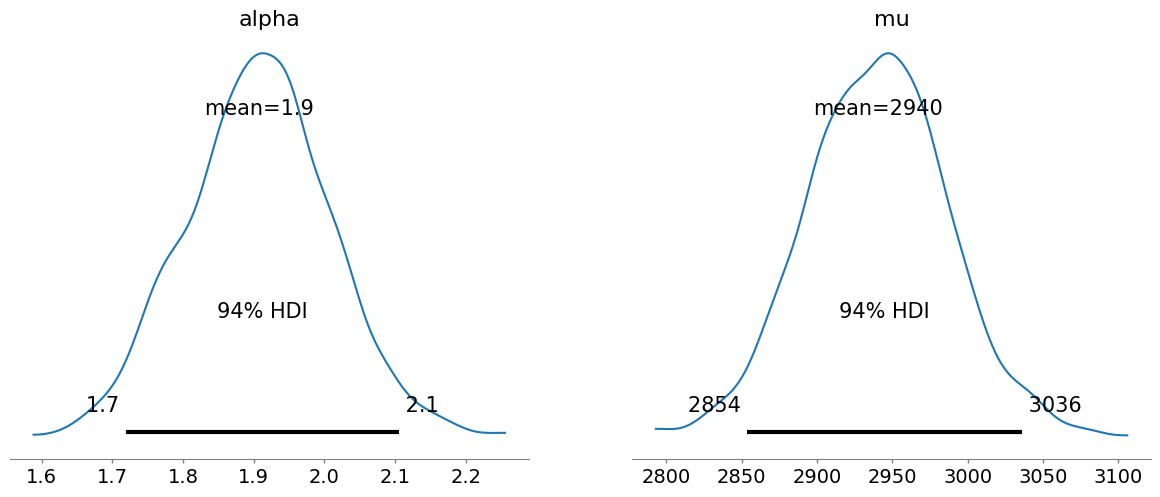

In [43]:
az.plot_posterior(sample_data)

In [ ]:
pm.sample_posterior_predictive(sample_data, model=viewer_model, extend_inferencedata=True)

<Axes: xlabel='y'>

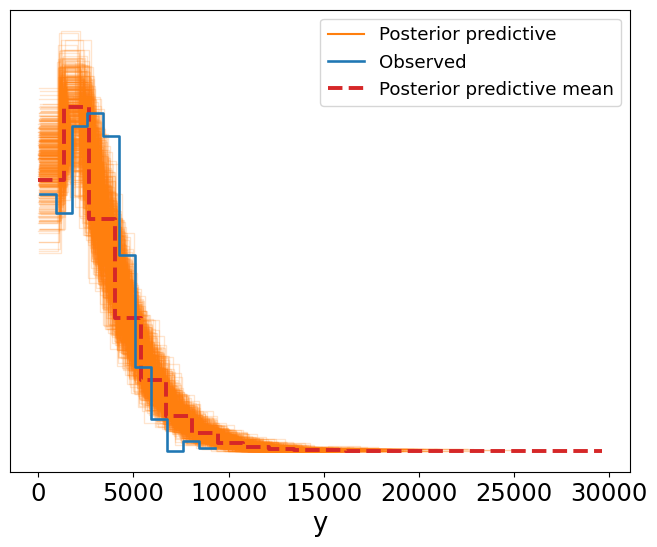

In [58]:
az.plot_ppc(sample_data, num_pp_samples=500, figsize=(8, 6), colors=["C1", "C0", "C3"])

##Conclusion

The model's mean seems to be about where it was expected (3000 thousand), there seems to be a pretty low variance, and the graph is very much a right skew. However, I don't know if the kurtosis matches very well, but that's likely due to me not entirely understanding what the look of the data meant. Besides that, the model is telling us that most Spongebob episodes will get about 2-3 million viewers on release, there's a good possibility they get lower, and unlikely to get much higher of a viewership. So overall, Spongebob episodes are pretty popular.